# Flight Delay Prediction

**Team 2 Cohort B**

Team Members: Anish Puthuraya, Mehul Agarwal, Sarmad Kahut, Jay Chaudhary 

## Introduction: Project Proposal & Objective

Flight delays are a big headache for carrier airlines as they not only incur unwanted costs for them, but they also suffer commercial loss due to change in flight schedules. The US domestic airline industry loses around 33 billion dollars annually due to aircraft delays which translates to $80 loss per minute. Delays are one of the biggest contributors towards lesser customer retention for airlines. Keeping all these things in mind, our predictive model is going to predict whether a flight would reach its destination on time or not, depending on multiple factors that have been explained in detail. 

## Data Source

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

Our data set is taken from the source Kaggle with the above link. The original dataset is titled “Flight Status Prediction”. The dataset consists of 61 columns and 29 million rows. The data is 4.01GB and spans a time period from June 2018 through June 2022. The data contains valuable flight information regarding delays, cancellations, airline information, and different time related information. 


## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Read Data

Since we have a large dataset which is a combination of multiple tables from different years, we have taken a sample of 200,000 records after combining all the tables. In order to explore the data, we have used histograms to get an understanding of the distribution throughout the sample dataset. 

In [2]:
data = pd.read_parquet("gs://ba810_flight_delay/Combined_Flights_Sample.parquet")

In [7]:
data.shape

(200000, 61)

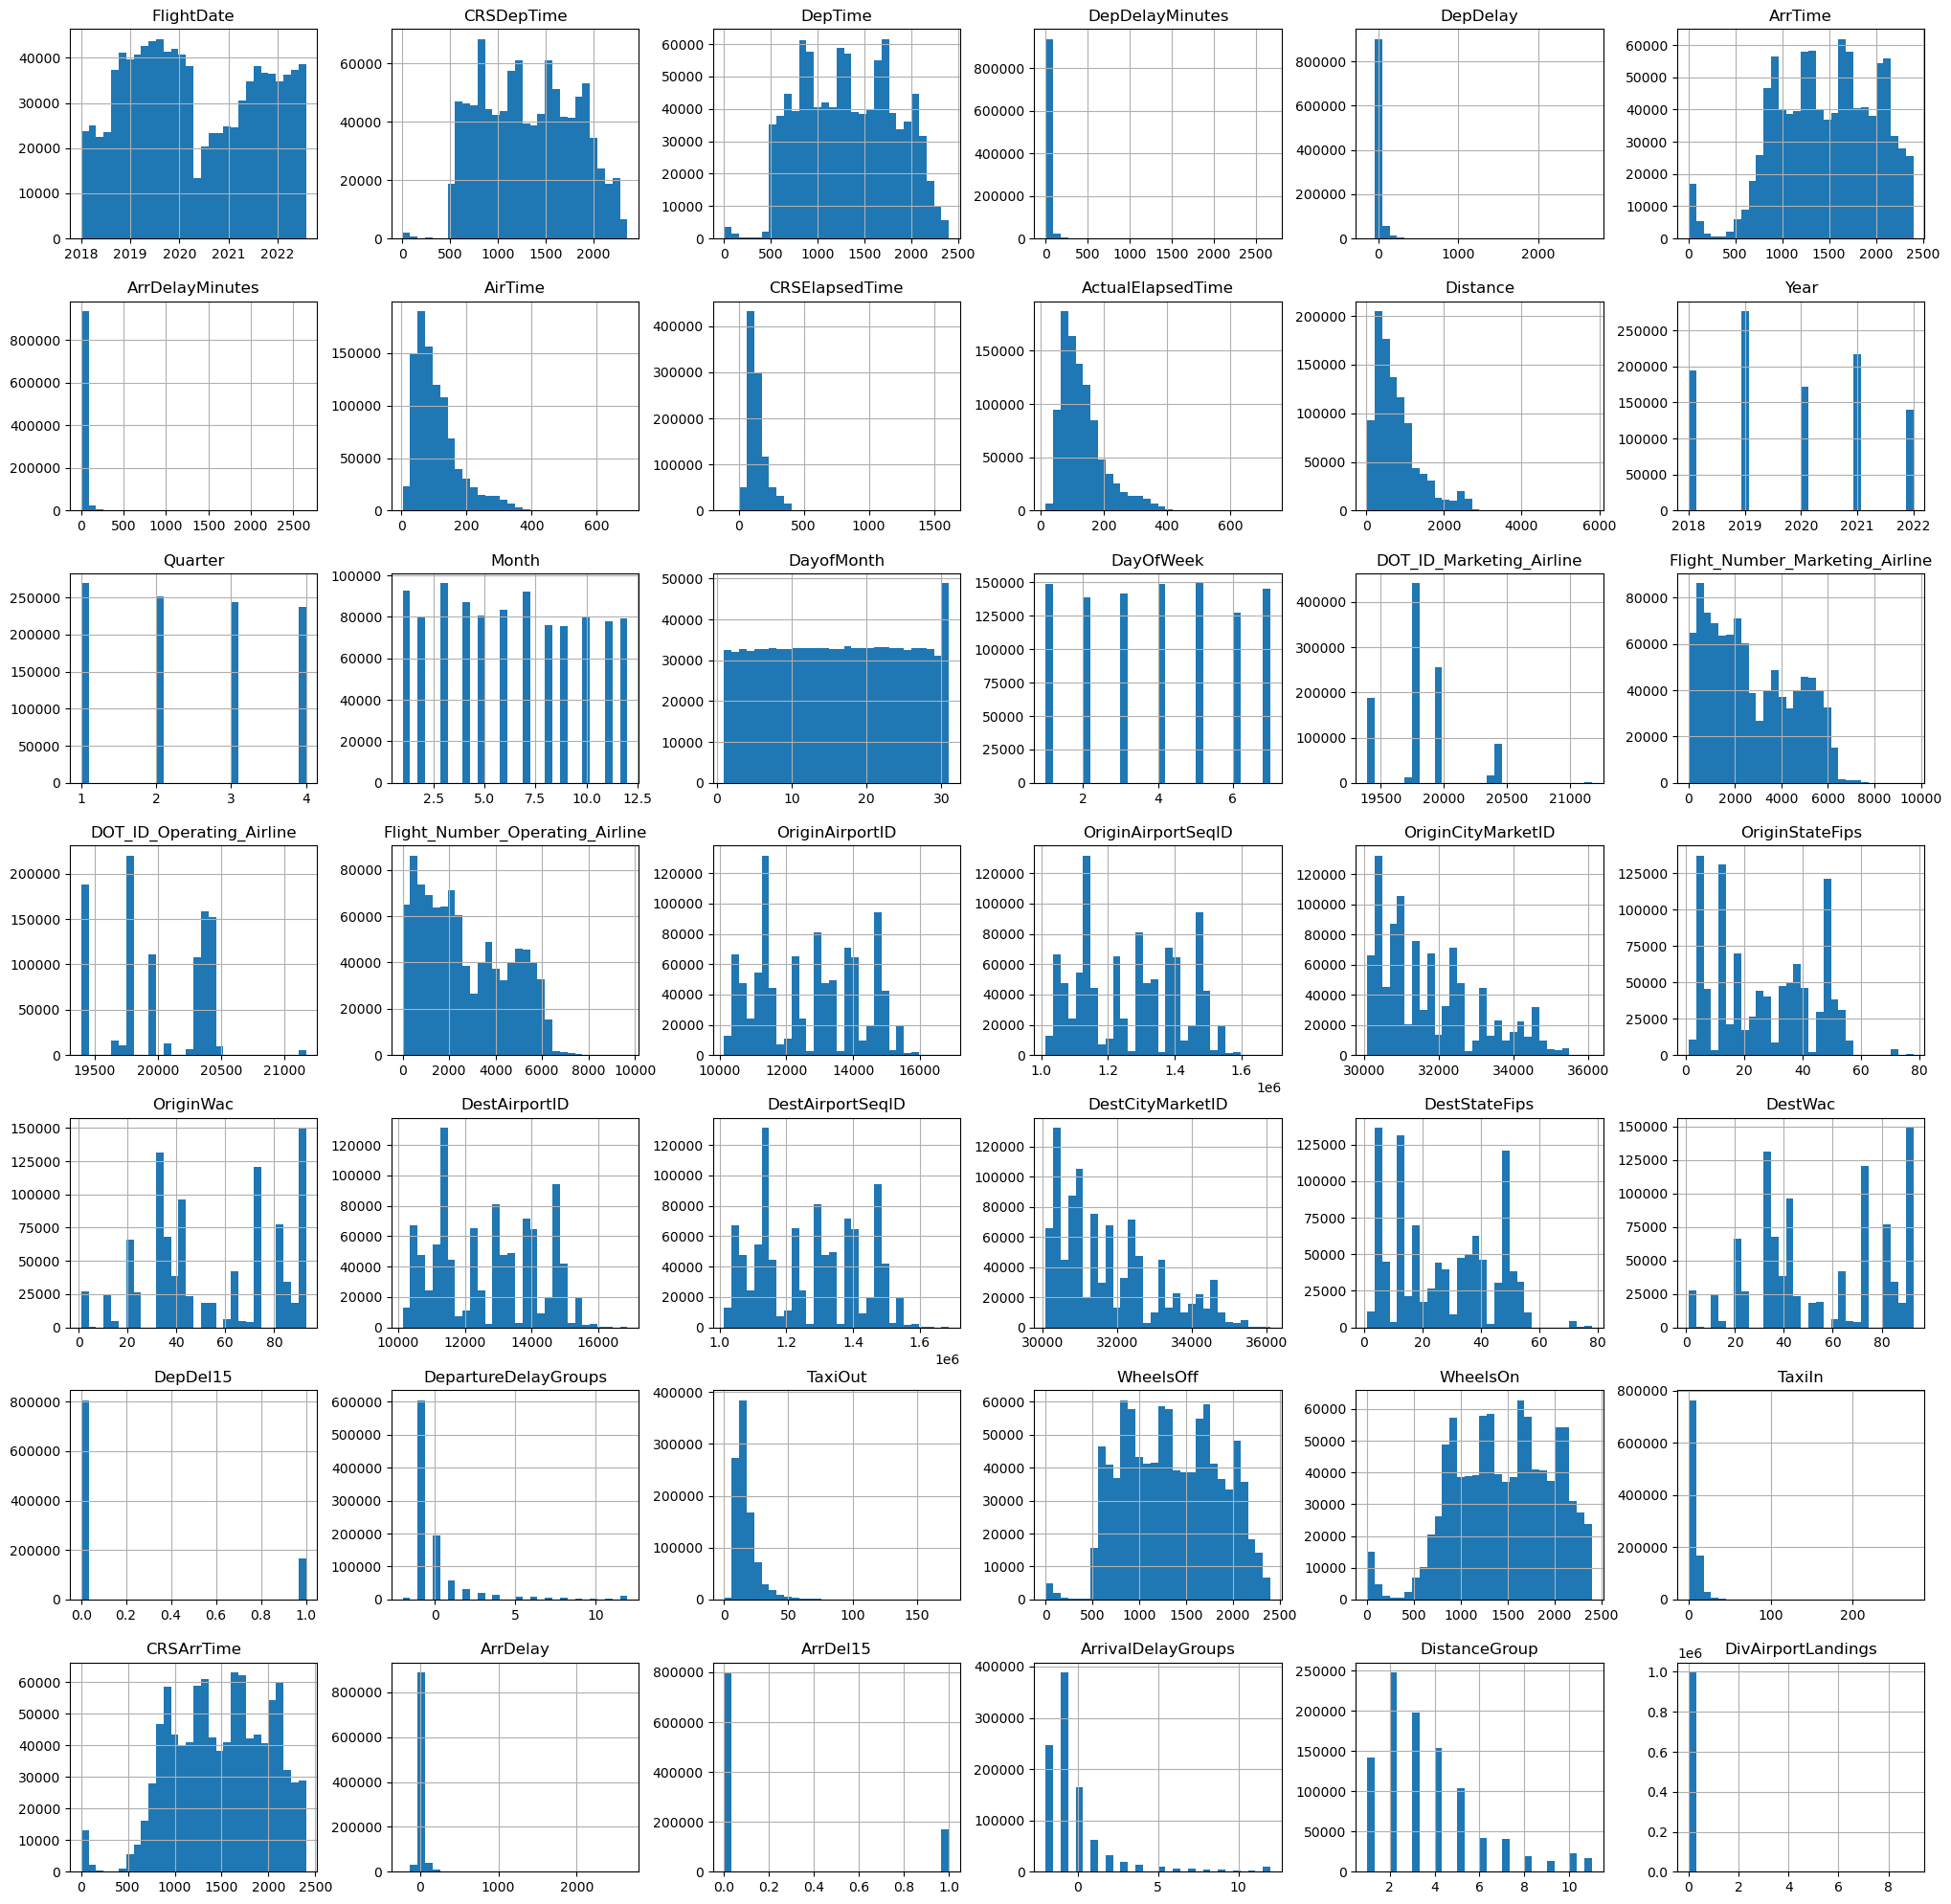

In [6]:
data.hist(bins=30, figsize=(25, 25));

# Select Columns

We dropped 10 columns that are listed below. The columns regarding delays made sense to drop because our traget variable was to predict delay. We determined that it wouldn't be reccomended to use delay to predict delay. For the column "FlightDate", we decided to drop because we had different columns that better represented the date of the data. 

In [3]:
columns_below_1_percent = data.corr()["ArrDel15"].sort_values(ascending=False)[
    abs(data.corr()["ArrDel15"].sort_values(ascending=False)) < 0.01
].index.to_list()

In [4]:
data_cd = data.drop(columns_below_1_percent, axis=1)
data_cd = data_cd.drop(
    ["FlightDate", "DOT_ID_Marketing_Airline", "DOT_ID_Operating_Airline", \
     "ArrivalDelayGroups", "DepartureDelayGroups", "DepDelayMinutes", "ArrDelayMinutes", "DepDelay", "ArrDelay", "DepDel15"]
, axis=1)

# Convert to Categorical

In this section we converted 19 columns to categorical variables. These categorical variables have no intrinsic ordering by definition and were converted to better serve our analysis. 

In [5]:
categorical_columns = ['Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'Marketing_Airline_Network', \
   'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', \
   'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginState', 'OriginStateName', \
   'DestCityName', 'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk']
data_cd[categorical_columns] = data_cd[categorical_columns].astype("category")

In [6]:
data_cd.loc[:, "ArrDel15"] = data_cd.loc[:, "ArrDel15"].astype("category")

## Modeling
The column “ArrDel15” was examined for null values. It appeared that this column had three possible values: Yes, No, and null. Yes indicating that a flight was delayed for more than 15 minutes, No indicating that the flight was not delayed, and null or no data present. Since these null values would be irrelevant to our analysis and cause our model to malfunction, they were dropped. 
### Remove Rows with Null for the target variable

In [7]:
data_cd[data_cd["ArrDel15"].isnull()].shape[0]

5809

In [8]:
data_cd = data_cd[~data_cd["ArrDel15"].isnull()]\
    .sample(100000)

### Split

In [9]:
X = data_cd.drop("ArrDel15", axis=1).reset_index(drop=True)
y = data_cd["ArrDel15"]

### Preprocessing

In the data preprocessing stage, we used simple imputation to replace null values with the mean while we used log pipeline in order to decrease the skewness among variables. Standard scalar has been used to normalise the distribution of numeric columns within the same range. Moreover, we have imputed the ‘mode’ value in missing categorical variables before combining all three to make another final table. 

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score,\
                            f1_score, roc_auc_score, RocCurveDisplay
from sklearn import set_config

set_config(display="diagram")

In [11]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"), StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"), FunctionTransformer(np.log10, validate=True), StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer(
    transformers = [
        ("num", num_pipeline, ['CRSDepTime', 'DepTime', 'ArrTime', 'OriginAirportID', 'OriginAirportSeqID', \
                                'OriginCityMarketID', 'OriginWac', 'DestWac', 'WheelsOff', 'WheelsOn', \
                                'CRSArrTime', 'DivAirportLandings', 'TaxiIn']),
        ("log", log_pipeline, ['AirTime', 'ActualElapsedTime', 'TaxiOut']),
        ("cat", cat_pipeline, make_column_selector(dtype_include = "category"))
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
RF_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", RandomForestClassifier(random_state=42))
])

In [ ]:
random_forest = RF_pipeline.fit(X_train, y_train)

In [26]:
balanced_accuracy_score(y_test, random_forest.predict(X_test))

0.6932180546735178

In [27]:
accuracy_score(y_test, random_forest.predict(X_test))

0.8882755211337233

# Neural Network

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
NN_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", MLPClassifier())
])

In [38]:
neural_network = NN_pipeline.fit(X_train, y_train)

In [39]:
balanced_accuracy_score(y_test, neural_network.predict(X_test))

0.873893368252523

In [40]:
accuracy_score(y_test, neural_network.predict(X_test))

0.9372785696630139

# XGBoost

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
XG_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", GradientBoostingClassifier())
])

In [43]:
xg_boost = XG_pipeline.fit(X_train, y_train)

In [44]:
balanced_accuracy_score(y_test, XG_pipeline.predict(X_test))

0.7174282709265978

In [45]:
accuracy_score(y_test, XG_pipeline.predict(X_test))

0.8962882096069869

# Ridge Classifier

In [46]:
from sklearn.linear_model import RidgeClassifierCV

In [47]:
RC_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", RidgeClassifierCV())
])

In [48]:
ridge_classifier = RC_pipeline.fit(X_train, y_train)

In [49]:
balanced_accuracy_score(y_test, ridge_classifier.predict(X_test))

0.5662285387689904

In [50]:
accuracy_score(y_test, ridge_classifier.predict(X_test))

0.8425681799456208

# AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
AD_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", AdaBoostClassifier())
])

In [53]:
ad_boost = AD_pipeline.fit(X_train, y_train)

In [54]:
balanced_accuracy_score(y_test, ad_boost.predict(X_test))

0.6118505490883431

In [55]:
accuracy_score(y_test, ad_boost.predict(X_test))

0.8509104391530032

# Support Vector Machine

In [13]:
from sklearn.svm import SVC

In [20]:
SVM_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", SVC())
])

In [58]:
svm_classifier = SVM_pipeline.fit(X_train, y_train)

In [59]:
balanced_accuracy_score(y_test, svm_classifier.predict(X_test))

0.8032258484847963

In [60]:
accuracy_score(y_test, svm_classifier.predict(X_test))

0.9272060641015077

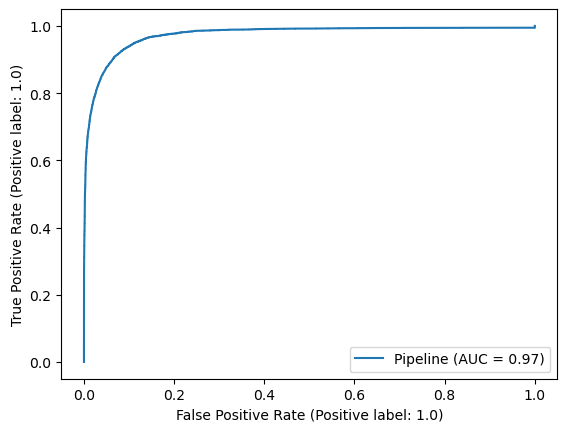

In [71]:
RocCurveDisplay.from_estimator(svm_classifier, X_test, y_test);

Out of all the predictive models used above, we can conclude that Super Vector Machine is producing the best results ( 0.92)which is why we shall be using this model for further working on our model. 

# Hyperparameter Tuning with Grid Search

In [42]:
param_grid = [
    {
        'model__kernel' : ["rbf"], 
        'model__C': [1, 10, 100, 1000]
    },
    {
        'model__kernel' : ["linear"],
        'model__C': [10, 100],
        'model__gamma': [0.001, 0.0001]
    }
]

In [43]:
grid_search = GridSearchCV(SVM_pipeline, param_grid, cv=3, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['CRSDepTime',
                                                                          'DepTime',
                                                                          'ArrTime',
                                                                          'OriginAirportID',
                                                                          'OriginAirportSeqID',
                                                                          'OriginCityMarketID',
                                                                          'OriginWac',
                                                                          'DestWac',
                                                                          'WheelsOff',
                                                                          'WheelsOn',
                                                                          'CRSArrTi...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8141749d0>)])),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [1, 10, 100, 1000],
                          'model__kernel': ['rbf']},
                         {'model__C': [10, 100],
                          'model__gamma': [0.001, 0.0001],
                          'model__kernel': ['linear']}],
             scoring='balanced_accuracy')

In [29]:
grid_search.best_params_

{'model__C': 10, 'model__kernel': 'rbf'}

While checking for the optimal hyperparameter values via grid search, it was found that the model would be most efficient when c value is 10 and kernel value is 'rbf'.

# Retrain the model with the best parameters



In [14]:
SVM_pipeline = Pipeline([
    ("preprocess", preprocessing),
    ("model", SVC(kernel = 'rbf', C = 10))
])

svm_classifier = SVM_pipeline.fit(X_train, y_train)

In [15]:
balanced_accuracy_score(y_test, svm_classifier.predict(X_test))

0.8629870001524432

In [17]:
accuracy_score(y_test, svm_classifier.predict(X_test))

0.93952

# Export Model

In [3]:
import pickle

In [36]:
filename = 'svm_model.sav'
pickle.dump(ad_boost, open(filename, 'wb'))

## Conclusion

Predicting anticipated flight delays is of huge value to both airline companies and the customer. An app interface like the one our team created linked above could be massively impacted when implemented in the market. An application backed by machine learning is of value to airline companies and businesses because it will allow them to determine where and when flights will be delayed. This knowledge will allow for more adequate staffing, resource allocation, and increased planning. Knowing this information, airlines can prevent airline delays which could lead to greater customer satisfaction. Airports can collaborate with airline companies to identify when increased traffic might occur and work to decrease both taxi out and taxi in time. Lowering taxi out and taxi in time will lead to a decrease in delayed flights. In conclusion, delayed flights result in a huge financial burden for airlines and result in a major inconvenience for customers. This contributes to lowered customer satisfaction. Successfully predicting and anticipating when, where, and which flights are likely to be delayed is extremely valuable. 